# Multiclass classification

<p><center>Before we get into writing code, let's look at the general architecture of a classification neural network:</center></p>
<center><img src="source_images/nn_architecture.png" width=600 height=600/></center>

* *Activation Functions*: https://en.wikipedia.org/wiki/Activation_function#Table_of_activation_functions

## 1. Get data ready

In [1]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
import torch
from torch import nn
import matplotlib.pyplot as plt

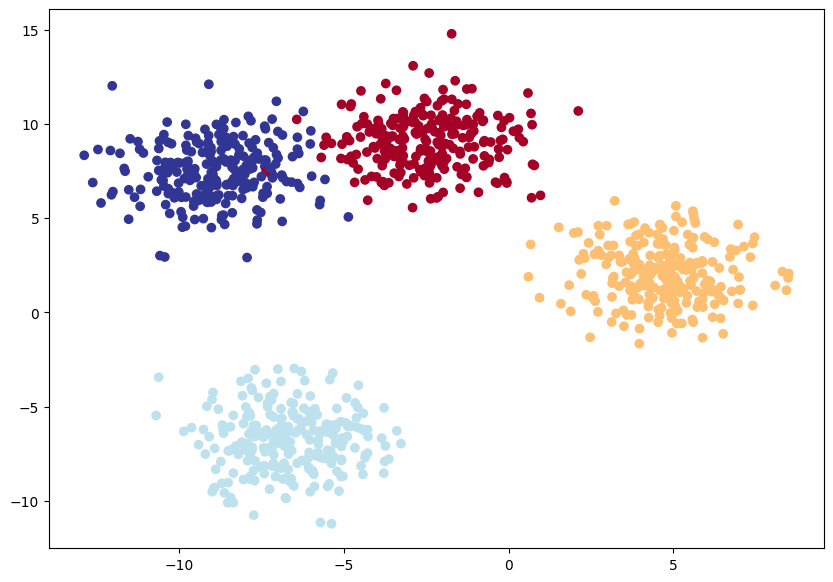

In [2]:
# Define processor device
device = 'mps' if torch.has_mps else 'cpu'

# Make 1,000 examples
n_samples = 1000

# Parameters
features = 2
classes = 4

# Create data values
X, y = make_blobs(n_samples, n_features = features, centers= classes, cluster_std=1.5, random_state=42)


plt.figure(figsize=(10,7))
plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.RdYlBu)
plt.show()

In [3]:
# Transform numpy arrays to tensors
X = torch.from_numpy(X).type(torch.float).to(device)
y = torch.from_numpy(y).type(torch.long).to(device)

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 2. Build Moldel

In [4]:
# Instanciate model
class MulticlassClass(nn.Module):
    # Constructor
    def __init__(self):
        super().__init__()
        # Define model
        self.model = nn.Sequential(
            nn.Linear(in_features=features, out_features=10),
            nn.ReLU(),
            nn.Linear(in_features=10, out_features=10),
            nn.ReLU(),
            nn.Linear(in_features=10, out_features=classes),
        ).to(device)
    
    # Define forward propagation
    def forward(self, x):
        return self.model(x)
    
# Inicialize model
model_0 = MulticlassClass()

# Define loss and optimization functions
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_0.parameters(), lr=0.1)

In [5]:
# Accuracy function
def accuracy(y_pred, y_true):
    return (y_pred == y_true).sum()/len(y_true)

## 3. Fit the model to data and make predictions

In [6]:
%%time

# Define muber of epochs
epochs = 1000

# Set lists to mesure results
epoch_count = []
train_loss_values = []
test_loss_values = []
acc_values = []

# Set seed
torch.manual_seed(42)

for epoch in range(epochs):
    # TRAIN MODEL
    model_0.train()

    # Forward prop
    y_train_logit = model_0(X_train)
    y_train_pred = y_train_logit.softmax(dim=1).argmax(dim=1)

    # Train measure 
    loss = loss_fn(y_train_logit, y_train)
    acc = accuracy(y_train_pred, y_train)

    # Backward prop
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    # EVALUATE MODEL
    model_0.eval()

    with torch.inference_mode():
        # Evaluate in test set
        y_test_logit = model_0(X_test)
        y_test_pred = y_test_logit.softmax(dim=1).argmax(dim=1)

        # Test measure 
        test_loss = loss_fn(y_test_logit, y_test)
        acc = accuracy(y_test_pred, y_test)
    
    # Print partial results
    if epoch % 10 == 0:
        epoch_count.append(epoch)
        train_loss_values.append(loss.cpu().detach().numpy())
        test_loss_values.append(test_loss.cpu().detach().numpy())
        acc_values.append(acc)
        print(f'Epoch: {epoch: 4d} | Acc: {acc: .4f} | Training loss: {loss: .4f} | Test loss: {test_loss: .4f}')

Epoch:    0 | Acc:  0.2300 | Training loss:  1.8095 | Test loss:  1.2317
Epoch:   10 | Acc:  0.9900 | Training loss:  0.2430 | Test loss:  0.2080
Epoch:   20 | Acc:  0.9950 | Training loss:  0.1001 | Test loss:  0.0888
Epoch:   30 | Acc:  0.9950 | Training loss:  0.0659 | Test loss:  0.0573
Epoch:   40 | Acc:  0.9950 | Training loss:  0.0516 | Test loss:  0.0435
Epoch:   50 | Acc:  0.9950 | Training loss:  0.0441 | Test loss:  0.0360
Epoch:   60 | Acc:  0.9950 | Training loss:  0.0396 | Test loss:  0.0314
Epoch:   70 | Acc:  0.9950 | Training loss:  0.0366 | Test loss:  0.0282
Epoch:   80 | Acc:  0.9950 | Training loss:  0.0344 | Test loss:  0.0259
Epoch:   90 | Acc:  0.9950 | Training loss:  0.0328 | Test loss:  0.0242
Epoch:  100 | Acc:  0.9950 | Training loss:  0.0316 | Test loss:  0.0228
Epoch:  110 | Acc:  0.9950 | Training loss:  0.0306 | Test loss:  0.0217
Epoch:  120 | Acc:  0.9950 | Training loss:  0.0298 | Test loss:  0.0208
Epoch:  130 | Acc:  0.9950 | Training loss:  0.0292

## 4. Model Tunning

<p><center>Focusing specifically on the model (not the data), there are a few ways we could improve it:</center></p>
<center><img src="source_images/improve_nn.png" width=600 height=600/></center>

## 5. Evaluate the model

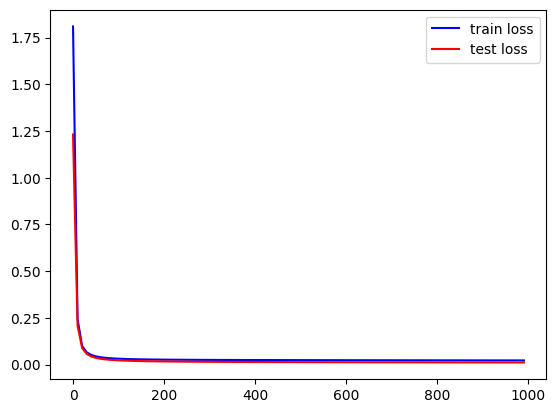

In [7]:
plt.plot(epoch_count, train_loss_values, c='b', label = 'train loss')
plt.plot(epoch_count, test_loss_values, c='r', label = 'test loss')
plt.legend();

/Users/andresg/Documents/PyTorch-Walkthrough/venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


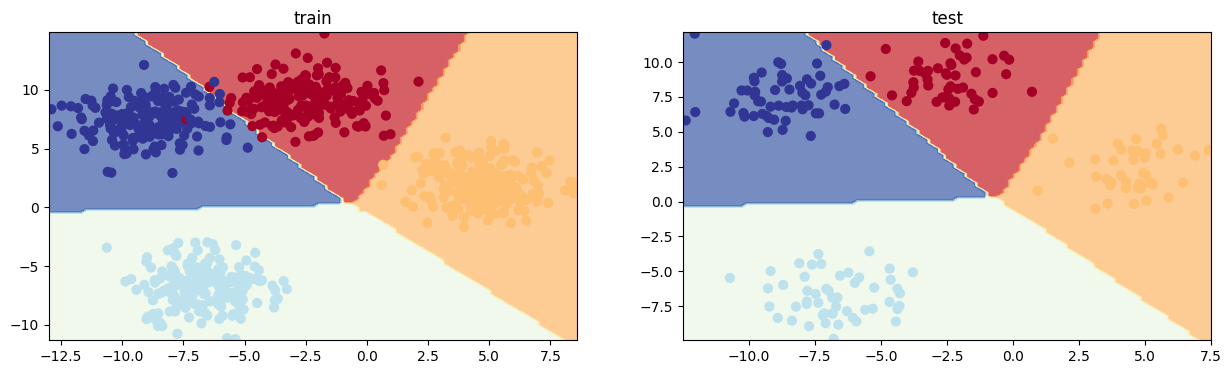

In [8]:
from helper_functions import plot_decision_boundary
plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.title('train')
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title('test')
plot_decision_boundary(model_0, X_test, y_test)

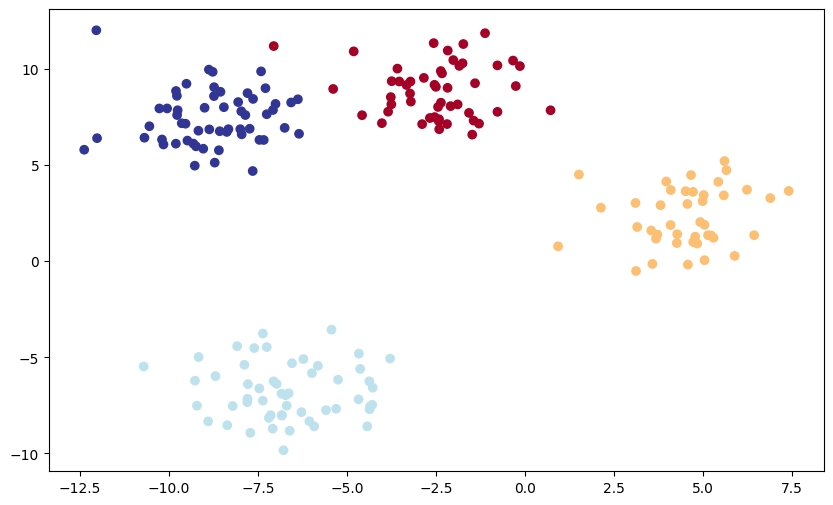

In [9]:
# Send model to device
model_0.to(device)
X, y = X.to(device), y.to(device)

# # Predictions
test_logits = model_0(X_test)
test_probs = test_logits.softmax(dim=1)
test_preds = test_probs.argmax(dim=1).cpu().detach().numpy()

# Plot predictions
plt.figure(figsize=(10, 6))
plt.scatter(X_test.cpu().detach().numpy().T[0], X_test.cpu().detach().numpy().T[1], c=test_preds, cmap=plt.cm.RdYlBu)
plt.show()

## 6. Save Model

In [10]:
import os
# Set folder and model name
folder_name = '../models'
model_name = 'MulticlassClassificationModel.pth'

# .pth: typically contains a serialized PyTorch state dictionary that contains the state of a PyTorch model, including the model's weights, biases, 
# and other parameters.

# Create folder if does not exist
if not os.path.exists(folder_name):
    os.mkdir(folder_name)

# Define path and save model state parameters
model_path = os.path.join(folder_name, model_name)
torch.save(obj=model_0.state_dict(), f=model_path)